In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cluster import Birch
from sklearn.metrics import mean_squared_error, r2_score
#import shap
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np


In [4]:
# Load and filter the data
df = pd.read_csv('kc_house_data.csv')
df = df[df['price'] <= 2000000]


In [5]:
# Preprocessing steps
df['date'] = pd.to_datetime(df['date'], format='%Y%m%dT%H%M%S')
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month


In [11]:
# Define features and target
important_features = ['sqft_living', 'yr_built', 'grade', 'zipcode']
other_features = ['bedrooms', 'bathrooms', 'sqft_lot', 'floors', 'waterfront', 'view', 'sqft_above', 'sqft_basement', 'yr_renovated', 'year', 'month', 'condition', 'lat', 'long']
all_features = important_features + other_features
target = 'price'
df.head()

id       date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520 2014-10-13  221900.0         3       1.00         1180   
1  6414100192 2014-12-09  538000.0         3       2.25         2570   
2  5631500400 2015-02-25  180000.0         2       1.00          770   
3  2487200875 2014-12-09  604000.0         4       3.00         1960   
4  1954400510 2015-02-18  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  view  ...  sqft_basement  yr_built  \
0      5650     1.0           0     0  ...              0      1955   
1      7242     2.0           0     0  ...            400      1951   
2     10000     1.0           0     0  ...              0      1933   
3      5000     1.0           0     0  ...            910      1965   
4      8080     1.0           0     0  ...              0      1987   

   yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  year  \
0             0    98178  47.5112 -122.257           1340        5650  2014   
1          1991    98125  47.7210 -122.319           1690        7639  2014   
2             0    98028  47.7379 -122.233           2720        8062  2015   
3             0    98136  47.5208 -122.393           1360        5000  2014   
4             0    98074  47.6168 -122.045           1800        7503  2015   

   month  
0     10  
1     12  
2      2  
3     12  
4      2  

[5 rows x 23 columns]

In [12]:
X = df[all_features]
y = df[target]

In [13]:
# FEATURE ENGINEERING -  combining lat and long so they can be viewed as one characteristic.
# Combine latitude and longitude into a single feature
X['location'] = list(zip(df.lat, df.long))

/var/folders/5s/8tvbf07s0sq4n2zrqz8g0ff40000gp/T/ipykernel_43717/3185299340.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['location'] = list(zip(df.lat, df.long))


In [14]:
# FEATURE ENGINEERING -  measure the distance from a home's location to the County/City's largest employers, Amazon, Starbucks, and Nordstums

# This computes probable commute time.


from math import radians, sin, cos, sqrt, atan2

# Function to calculate distance using Haversine formula
def haversine(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    r = 6371  # Radius of Earth in kilometers
    return r * c

# Define city center coordinates (example: downtown coordinates)
city_center_lat = 47.615257
city_center_lon = -122.338356

# Calculate distance to city center for each row
X['distance_to_Seattle'] = X.apply(lambda row: haversine(row['lat'], row['long'], city_center_lat, city_center_lon), axis=1)

# Display the DataFrame with the new distance_to_center feature
print(X[['lat', 'long', 'distance_to_Seattle']])

           lat     long  distance_to_Seattle
0      47.5112 -122.257            13.082094
1      47.7210 -122.319            11.847081
2      47.7379 -122.233            15.754191
3      47.5208 -122.393            11.274888
4      47.6168 -122.045            21.989458
...        ...      ...                  ...
21608  47.6993 -122.346             9.362676
21609  47.5107 -122.362            11.760782
21610  47.5944 -122.299             3.752959
21611  47.5345 -122.069            22.111252
21612  47.5941 -122.299             3.773671

[21415 rows x 3 columns]


/var/folders/5s/8tvbf07s0sq4n2zrqz8g0ff40000gp/T/ipykernel_43717/2921534653.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['distance_to_Seattle'] = X.apply(lambda row: haversine(row['lat'], row['long'], city_center_lat, city_center_lon), axis=1)


In [15]:
# FEATURE ENGINEERING -  measure the distance from a home's location to MSFT HQ
# This computes probable commute time.


# Function to calculate distance using Haversine formula
def haversine(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    r = 6371  # Radius of Earth in kilometers
    return r * c

# Define city center coordinates (example: downtown coordinates)
MSFT_lat = 47.643543
MSFT_lon = -122.130821

# Calculate distance to city center for each row
X['distance_to_MSFT'] = X.apply(lambda row: haversine(row['lat'], row['long'], MSFT_lat, MSFT_lon), axis=1)

# Display the DataFrame with the new distance_to_center feature
print(X[['lat', 'long', 'distance_to_MSFT']])

           lat     long  distance_to_MSFT
0      47.5112 -122.257         17.496867
1      47.7210 -122.319         16.511564
2      47.7379 -122.233         12.983608
3      47.5208 -122.393         23.936895
4      47.6168 -122.045          7.085291
...        ...      ...               ...
21608  47.6993 -122.346         17.263568
21609  47.5107 -122.362         22.779616
21610  47.5944 -122.299         13.738786
21611  47.5345 -122.069         12.981182
21612  47.5941 -122.299         13.752121

[21415 rows x 3 columns]


/var/folders/5s/8tvbf07s0sq4n2zrqz8g0ff40000gp/T/ipykernel_43717/3679602632.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['distance_to_MSFT'] = X.apply(lambda row: haversine(row['lat'], row['long'], MSFT_lat, MSFT_lon), axis=1)


In [16]:
# FEATURE ENGINEERING -  measure the distance from a home's location to Boeing Seatle Offices
# This computes probable commute time.


# Function to calculate distance using Haversine formula
def haversine(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    r = 6371  # Radius of Earth in kilometers
    return r * c

# Define city center coordinates (example: downtown coordinates)
Boeing_lat = 47.532733
Boeing_lon = -122.316916

# Calculate distance to city center for each row
X['distance_to_Boeing'] = X.apply(lambda row: haversine(row['lat'], row['long'], Boeing_lat, Boeing_lon), axis=1)

# Display the DataFrame with the new distance_to_center feature
print(X[['lat', 'long', 'distance_to_Boeing']])

           lat     long  distance_to_Boeing
0      47.5112 -122.257            5.096588
1      47.7210 -122.319           20.934918
2      47.7379 -122.233           23.664150
3      47.5208 -122.393            5.864758
4      47.6168 -122.045           22.437740
...        ...      ...                 ...
21608  47.6993 -122.346           18.649261
21609  47.5107 -122.362            4.178909
21610  47.5944 -122.299            6.987580
21611  47.5345 -122.069           18.613097
21612  47.5941 -122.299            6.954848

[21415 rows x 3 columns]


/var/folders/5s/8tvbf07s0sq4n2zrqz8g0ff40000gp/T/ipykernel_43717/45864648.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['distance_to_Boeing'] = X.apply(lambda row: haversine(row['lat'], row['long'], Boeing_lat, Boeing_lon), axis=1)


In [17]:
# FEATURE ENGINEERING - Identify a house to a school district and how that school district ranks
# This coputes the quality of public education

# Define the school district rankings
school_districts = {
    1: 'Bellevue',
    2: 'Mercer Island',
    3: 'Lake Washington',
    4: 'Issaquah',
    5: 'Shoreline',
    6: 'Vashon Island',
    7: 'Tahoma',
    8: 'All Others'
}

# Define zip code to school district mapping
zip_to_district = {
    98004: 1, 98005: 1, 98006: 1, 98007: 1, 98008: 1,  # Bellevue
    98040: 2,                                        # Mercer Island
    98033: 3, 98034: 3, 98072: 3, 98074: 3, 98052: 3, # Lake Washington
    98027: 4, 98029: 4, 98075: 4, 98038: 4,           # Issaquah
    98155: 5, 98133: 5, 98177: 5, 98160: 5,           # Shoreline
    98070: 6,                                        # Vashon Island
    98038: 7                                         # Tahoma
}

# Assign 'All Others' (rank 8) to zip codes not explicitly listed
X['school_district_rank'] = X['zipcode'].map(zip_to_district).fillna(8)

# Display the DataFrame with the new school_district feature
print(X[['zipcode', 'school_district_rank']])

       zipcode  school_district_rank
0        98178                   8.0
1        98125                   8.0
2        98028                   8.0
3        98136                   8.0
4        98074                   3.0
...        ...                   ...
21608    98103                   8.0
21609    98146                   8.0
21610    98144                   8.0
21611    98027                   4.0
21612    98144                   8.0

[21415 rows x 2 columns]


In [18]:
# FEATURE ENGINEERING - Area Type - Identifying a home as being in an urban area vs suburban vs rural  

# Zip code classification
urban_zips = {'98101', '98102', '98103', '98104', '98105', '98106', '98107', '98108', '98109', '98112', '98115', '98116', '98117', '98118', '98119', '98121', '98122', '98125', '98126', '98133', '98134', '98136', '98144', '98146', '98148', '98154', '98155', '98158', '98160', '98161', '98164', '98166', '98168', '98174', '98177', '98178', '98188', '98198', '98199'}
suburban_zips = {'98001', '98002', '98003', '98004', '98005', '98006', '98007', '98008', '98010', '98011', '98014', '98019', '98022', '98023', '98024', '98025', '98027', '98028', '98029', '98030', '98031', '98032', '98033', '98034', '98038', '98039', '98040', '98042', '98045', '98047', '98050', '98051', '98052', '98053', '98055', '98056', '98057', '98058', '98059', '98062', '98063', '98064', '98065', '98070', '98072', '98073', '98074', '98075', '98077', '98092', '98093'}

def classify_zipcode(zipcode):
    if zipcode in urban_zips:
        return 0  # Urban
    elif zipcode in suburban_zips:
        return 1  # Suburban
    else:
        return 2  # Rural

# Apply the classification to the DataFrame
X['area_type'] = X['zipcode'].apply(lambda x: classify_zipcode(str(x)))

# Display the resulting DataFrame
print(X)

       sqft_living  yr_built  grade  zipcode  bedrooms  bathrooms  sqft_lot  \
0             1180      1955      7    98178         3       1.00      5650   
1             2570      1951      7    98125         3       2.25      7242   
2              770      1933      6    98028         2       1.00     10000   
3             1960      1965      7    98136         4       3.00      5000   
4             1680      1987      8    98074         3       2.00      8080   
...            ...       ...    ...      ...       ...        ...       ...   
21608         1530      2009      8    98103         3       2.50      1131   
21609         2310      2014      8    98146         4       2.50      5813   
21610         1020      2009      7    98144         2       0.75      1350   
21611         1600      2004      8    98027         3       2.50      2388   
21612         1020      2008      7    98144         2       0.75      1076   

       floors  waterfront  view  ...  month  condit

In [19]:
# FEATURE ENGINEERING - Deterine the housing density by zip code via accessing the US Census data.
#  Combined with 

import requests
import pandas as pd

# Your valid U.S. Census API key
api_key = 'da7546bc69f821495474c275ba74ac0c5ba32a7c'

# Base URL for the API
base_url = "https://api.census.gov/data/2020/acs/acs5"

# Parameters for the API request for housing units
params_housing = {
    "get": "B25001_001E",  # Total housing units
    "for": "zip code tabulation area:*",
    "key": api_key
}

# Parameters for the API request for population
params_population = {
    "get": "B01003_001E",  # Total population
    "for": "zip code tabulation area:*",
    "key": api_key
}

# Function to fetch data from Census API
def fetch_census_data(params):
    response = requests.get(base_url, params=params)
    if response.status_code == 200:
        try:
            return response.json()
        except ValueError:
            print("Error: Response content is not valid JSON")
            print(response.text)
            return None
    else:
        print(f"Error: Received response with status code {response.status_code}")
        print(response.text)
        return None

# Fetch housing data
housing_data = fetch_census_data(params_housing)
if housing_data:
    # Convert the housing data to a pandas DataFrame
    columns_housing = housing_data[0]
    data_housing_rows = housing_data[1:]
    df_housing = pd.DataFrame(data_housing_rows, columns=columns_housing)
    df_housing['B25001_001E'] = pd.to_numeric(df_housing['B25001_001E'])
    df_housing['zip code tabulation area'] = df_housing['zip code tabulation area'].astype(str)

# Fetch population data
population_data = fetch_census_data(params_population)
if population_data:
    # Convert the population data to a pandas DataFrame
    columns_population = population_data[0]
    data_population_rows = population_data[1:]
    df_population = pd.DataFrame(data_population_rows, columns=columns_population)
    df_population['B01003_001E'] = pd.to_numeric(df_population['B01003_001E'])
    df_population['zip code tabulation area'] = df_population['zip code tabulation area'].astype(str)

# List of zip codes in King County (source: external reliable source or predefined list)
king_county_zip_codes = [
    '98001', '98002', '98003', '98004', '98005', '98006', '98007', '98008', '98010', '98011', '98014', '98019', 
    '98022', '98023', '98024', '98025', '98027', '98028', '98029', '98030', '98031', '98032', '98033', '98034',
    '98038', '98039', '98040', '98042', '98045', '98047', '98050', '98051', '98052', '98053', '98055', '98056',
    '98057', '98058', '98059', '98062', '98063', '98064', '98065', '98070', '98072', '98073', '98074', '98075',
    '98077', '98092', '98093', '98101', '98102', '98103', '98104', '98105', '98106', '98107', '98108', '98109',
    '98112', '98115', '98116', '98117', '98118', '98119', '98121', '98122', '98125', '98126', '98133', '98134',
    '98136', '98144', '98146', '98148', '98154', '98155', '98158', '98160', '98161', '98164', '98166', '98168',
    '98174', '98177', '98178', '98188', '98198', '98199'
]

# Filter data for King County zip codes
if housing_data and population_data:
    df_housing_king = df_housing[df_housing['zip code tabulation area'].isin(king_county_zip_codes)]
    df_population_king = df_population[df_population['zip code tabulation area'].isin(king_county_zip_codes)]
    
    # Merge the two DataFrames on the zip code tabulation area
    df_merged = pd.merge(df_housing_king, df_population_king, on='zip code tabulation area')
    
    # Calculate housing density (total housing units per population)
    df_merged['housing_density'] = df_merged['B25001_001E'] / df_merged['B01003_001E']
    
    # Rank the zip codes by housing density
    #df_merged['density_rank'] = df_merged['housing_density'].rank(ascending=False)
    
    # Display the DataFrame with the housing density and rank
    print(df_merged[['zip code tabulation area', 'housing_density']])

   zip code tabulation area  housing_density
0                     98001         0.347729
1                     98002         0.421098
2                     98003         0.390656
3                     98004         0.522045
4                     98005         0.411973
..                      ...              ...
77                    98177         0.409656
78                    98178         0.385634
79                    98188         0.423691
80                    98198         0.393395
81                    98199         0.462123

[82 rows x 2 columns]


In [20]:
# Rename column to match X DataFrame for merging
df_merged.rename(columns={'zip code tabulation area': 'zipcode'}, inplace=True)
# Convert zipcode to string for merging
X['zipcode'] = X['zipcode'].astype(str)

# Merge the housing density and rank into X based on zipcode
X = pd.merge(X, df_merged, on='zipcode', how='left')
X.head()

sqft_living  yr_built  grade zipcode  bedrooms  bathrooms  sqft_lot  \
0         1180      1955      7   98178         3       1.00      5650   
1         2570      1951      7   98125         3       2.25      7242   
2          770      1933      6   98028         2       1.00     10000   
3         1960      1965      7   98136         4       3.00      5000   
4         1680      1987      8   98074         3       2.00      8080   

   floors  waterfront  view  ...     long             location  \
0     1.0           0     0  ... -122.257  (47.5112, -122.257)   
1     2.0           0     0  ... -122.319   (47.721, -122.319)   
2     1.0           0     0  ... -122.233  (47.7379, -122.233)   
3     1.0           0     0  ... -122.393  (47.5208, -122.393)   
4     1.0           0     0  ... -122.045  (47.6168, -122.045)   

   distance_to_Seattle  distance_to_MSFT  distance_to_Boeing  \
0            13.082094         17.496867            5.096588   
1            11.847081         16.511564           20.934918   
2            15.754191         12.983608           23.664150   
3            11.274888         23.936895            5.864758   
4            21.989458          7.085291           22.437740   

   school_district_rank  area_type  B25001_001E B01003_001E  housing_density  
0                   8.0          0        10222       26507         0.385634  
1                   8.0          0        20946       44030         0.475721  
2                   8.0          1         9666       22953         0.421121  
3                   8.0          0         8272       17083         0.484224  
4                   3.0          1         9779       29349         0.333197  

[5 rows x 27 columns]

In [22]:
columns_to_drop=['lat','long','B25001_001E','B01003_001E']
X=X.drop(columns=columns_to_drop)
X.head()

sqft_living  yr_built  grade zipcode  bedrooms  bathrooms  sqft_lot  \
0         1180      1955      7   98178         3       1.00      5650   
1         2570      1951      7   98125         3       2.25      7242   
2          770      1933      6   98028         2       1.00     10000   
3         1960      1965      7   98136         4       3.00      5000   
4         1680      1987      8   98074         3       2.00      8080   

   floors  waterfront  view  ...  year  month  condition             location  \
0     1.0           0     0  ...  2014     10          3  (47.5112, -122.257)   
1     2.0           0     0  ...  2014     12          3   (47.721, -122.319)   
2     1.0           0     0  ...  2015      2          3  (47.7379, -122.233)   
3     1.0           0     0  ...  2014     12          5  (47.5208, -122.393)   
4     1.0           0     0  ...  2015      2          3  (47.6168, -122.045)   

   distance_to_Seattle  distance_to_MSFT distance_to_Boeing  \
0            13.082094         17.496867           5.096588   
1            11.847081         16.511564          20.934918   
2            15.754191         12.983608          23.664150   
3            11.274888         23.936895           5.864758   
4            21.989458          7.085291          22.437740   

   school_district_rank  area_type  housing_density  
0                   8.0          0         0.385634  
1                   8.0          0         0.475721  
2                   8.0          1         0.421121  
3                   8.0          0         0.484224  
4                   3.0          1         0.333197  

[5 rows x 23 columns]

In [23]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [30]:
# Define numerical and categorical columns
numerical_cols = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'bathrooms', 'bedrooms', 'floors',  'grade', 'distance_to_Seattle', 'distance_to_MSFT', 'distance_to_Boeing', 'school_district_rank', 'area_type', 'housing_density']
categorical_cols = ['zipcode', 'waterfront', 'view', 'condition',]


In [31]:
# Preprocessing for numerical data: polynomial features and power transformation
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('power', PowerTransformer(method='yeo-johnson')),
    ('poly', PolynomialFeatures(degree=2, include_bias=False))
])


In [32]:
# Preprocessing for categorical data: one-hot encoding
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


In [33]:
# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])


In [34]:
# Define models
models = {
    'GradientBoosting': GradientBoostingRegressor(),
    'RandomForest': RandomForestRegressor(),
    'KNN': KNeighborsRegressor()
}


In [ ]:
# Create and evaluate pipelines
param_grids = {
    'GradientBoosting': {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.01, 0.1],
        'model__max_depth': [3, 5, 7]
    },
    'RandomForest': {
        'model__n_estimators': [100, 200],
        'model__max_depth': [10, 20, 30]
    },
    'KNN': {
        'model__n_neighbors': range(1, 21)
    }
}

best_models = {}

for name, model in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', model)])
    param_grid = param_grids[name]
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_models[name] = grid_search.best_estimator_
    print(f"Best parameters for {name}: ", grid_search.best_params_)
    print(f"Best R2 score for {name}: ", grid_search.best_score_)

In [ ]:
# Evaluate on the test set
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    print(f"Test R2 score for {name}: ", r2_score(y_test, y_pred))

In [ ]:
# BIRCH Clustering
birch = Birch(n_clusters=5)
birch.fit(preprocessor.fit_transform(X_train))
birch_labels = birch.predict(preprocessor.transform(X_train))

In [ ]:
# Get feature names for numerical and categorical features
numerical_feature_names = preprocessor.transformers_[0][1].named_steps['poly'].get_feature_names_out(numerical_cols)
categorical_feature_names = preprocessor.transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_cols)


In [ ]:
# Combine feature names
feature_names = list(numerical_feature_names) + list(categorical_feature_names)

In [17]:
# Combine feature names
feature_names = list(numerical_feature_names) + list(categorical_feature_names)

# Feature importance from Random Forest
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': best_models['RandomForest'].named_steps['model'].feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance.head(20))


Feature Importance:
                       feature  importance
0                  sqft_living    0.417132
57               zipcode_98004    0.042331
9                sqft_living^2    0.034355
13        sqft_living yr_built    0.027974
143                    grade_9    0.021864
21           sqft_lot yr_built    0.020007
142                    grade_8    0.019792
141                    grade_7    0.018208
144                   grade_10    0.016346
79               zipcode_98040    0.012546
126                     view_0    0.012501
4                     yr_built    0.012100
28         sqft_above yr_built    0.011518
27    sqft_above sqft_basement    0.010664
17          sqft_living floors    0.010024
145                   grade_11    0.009764
12   sqft_living sqft_basement    0.008936
75               zipcode_98033    0.008833
41          yr_built bathrooms    0.008751
102              zipcode_98112    0.008409


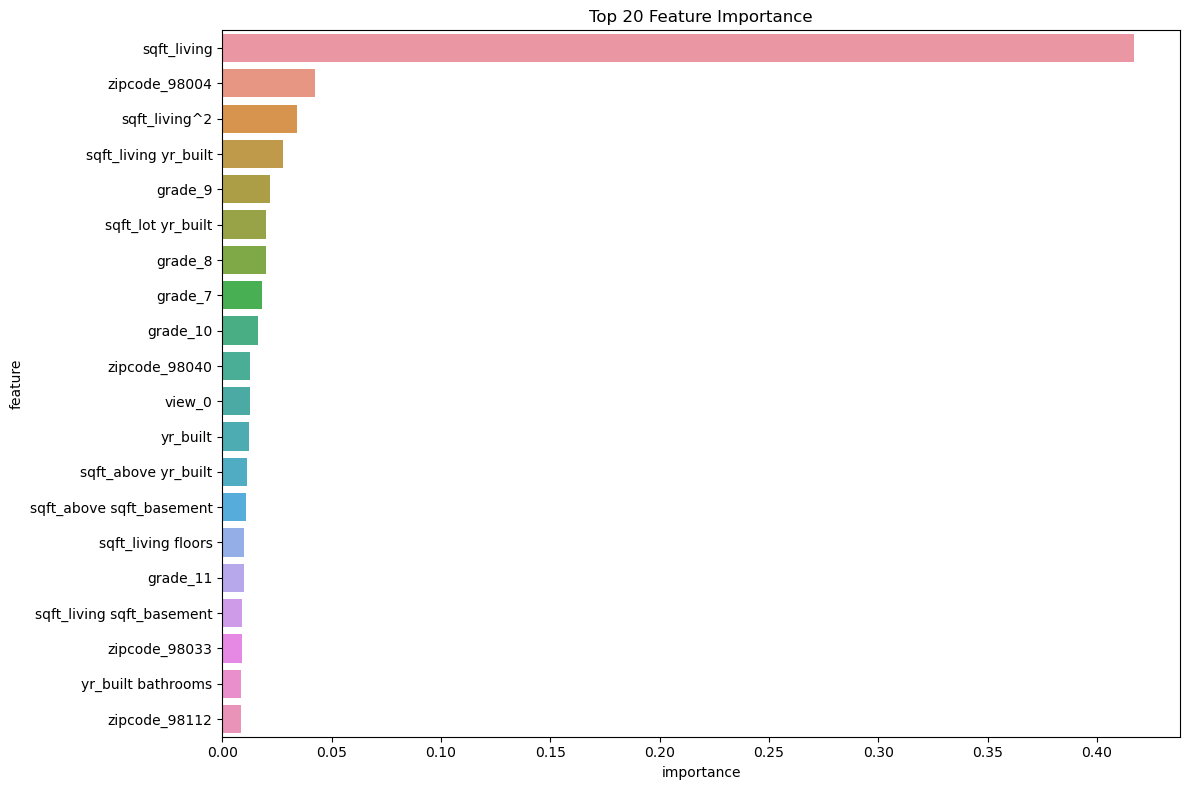

In [20]:
# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance.head(20))
plt.title('Top 20 Feature Importance')
plt.tight_layout()
plt.savefig('feature_importance.png')



100%|===================| 17129/17132 [61:26<00:00]        

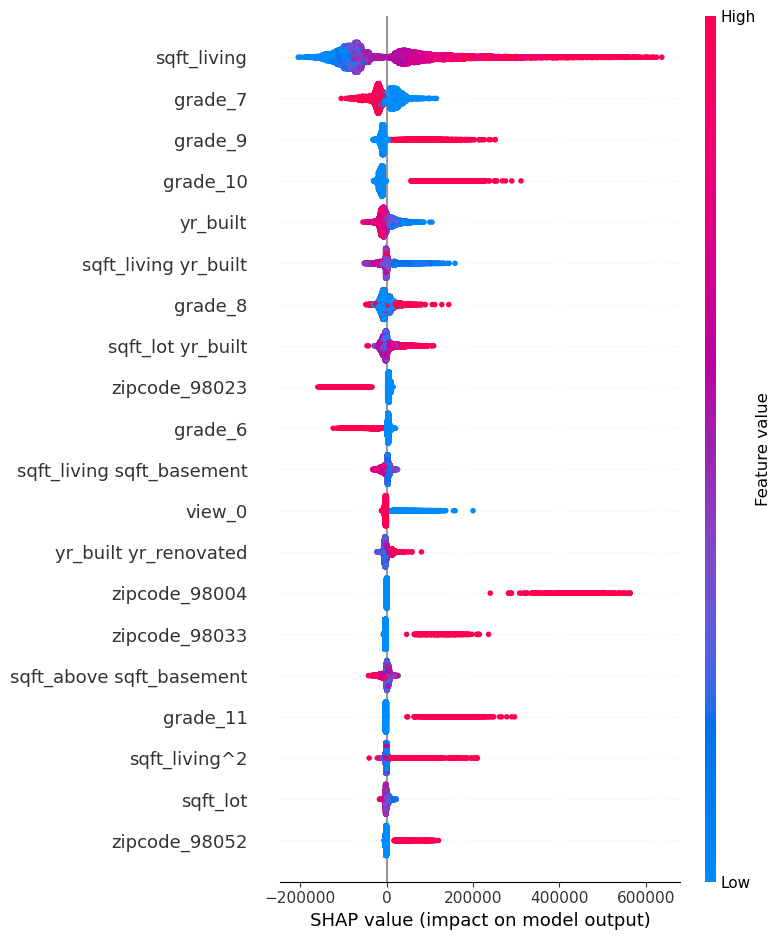

In [19]:
# SHAP values for model interpretability
#explainer = shap.Explainer(best_models['RandomForest'].named_steps['model'], preprocessor.transform(X_train))
#shap_values = explainer.shap_values(preprocessor.transform(X_train))

#shap.summary_plot(shap_values, preprocessor.transform(X_train), feature_names=feature_names)

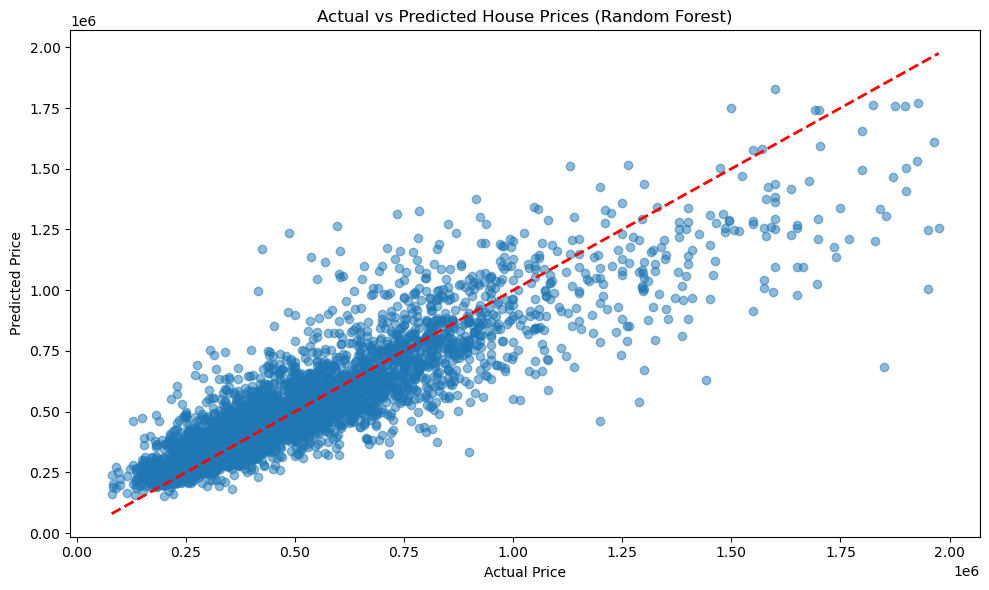

In [21]:
# Scatter plot of actual vs predicted prices (Random Forest)
y_pred_rf = best_models['RandomForest'].predict(X_test)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted House Prices (Random Forest)')
plt.tight_layout()
plt.savefig('actual_vs_predicted_rf.png')

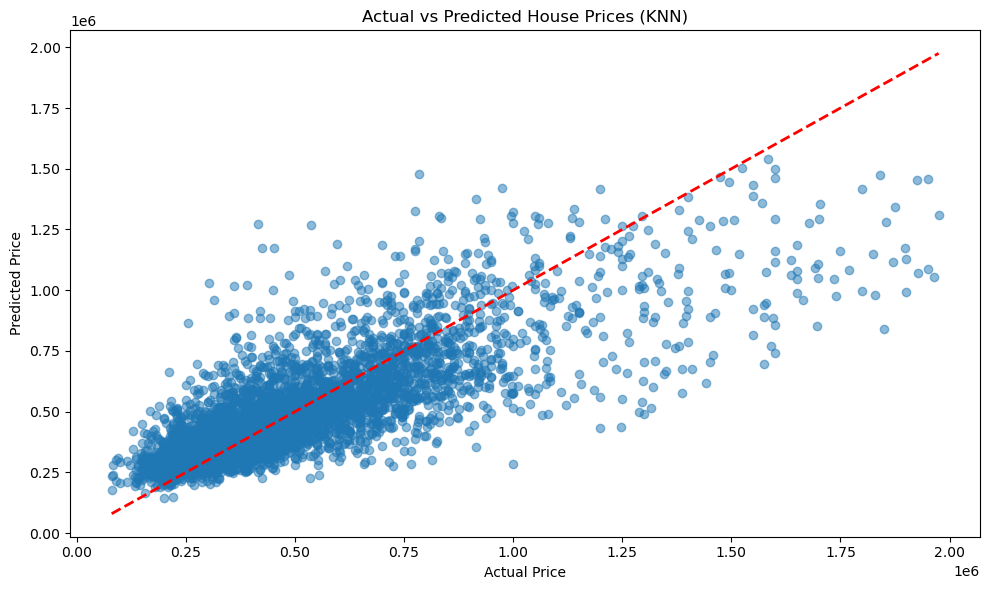

In [22]:
# Scatter plot of actual vs predicted prices (KNN)
y_pred_knn = best_models['KNN'].predict(X_test)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_knn, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted House Prices (KNN)')
plt.tight_layout()
plt.savefig('actual_vs_predicted_knn.png')

In [23]:
# BIRCH Clustering visualization
X_train_transformed = preprocessor.transform(X_train)
plt.figure(figsize=(10, 6))
plt.scatter(X_train_transformed[:, 0], X_train_transformed[:, 1], c=birch_labels, cmap='viridis', alpha=0.5)
plt.title('BIRCH Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster')
plt.savefig('birch_clustering.png')
plt.close()


In [24]:
# Save results
results = pd.DataFrame({
    'Actual': y_test,
    'KNN Predicted': best_models['KNN'].predict(X_test),
    'RF Predicted': best_models['RandomForest'].predict(X_test)
})
results.to_csv('prediction_results.csv', index=False)
print("Analysis complete. Check the output files for results and visualizations.")

Analysis complete. Check the output files for results and visualizations.
